In [9]:
import sys
sys.path.append('../')
from lib.matrix_approach.layers import *
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import torch
import numpy as np
import random
from collections import deque
from IPython import display, embed
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 1
n_episodes = 10000

In [11]:
class NN(Network):

    def __init__(self):
        self.layers = [
            FC(state_size, 24),
            ReLU(),
            FC(24, 24),
            ReLU(),
            FC(24, action_size)
        ]

    def __call__(self, input):
        input = np.array(input)
        return self.forward(input)

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size, model):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.learning_rate = 0.001
        self.model = model
        self.loss_fn = MSE()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

    def act(self, state, eval=False):
        if not eval and np.random.rand() <= self.epsilon:
            # return random.randrange(self.action_size)
            return random.choices([0,1], weights=[10, 10])[0]
        act_values = self.model([state])
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([m[0] for m in minibatch])
        actions = np.array([m[1] for m in minibatch])
        rewards = np.array([m[2] for m in minibatch])
        next_states = np.array([m[3] for m in minibatch])
        dones = np.array([m[4] for m in minibatch])
        dones_idx = np.nonzero(dones)[0]

        outputs = self.model(next_states)
        targets = rewards + self.gamma * np.amax(outputs, axis=1)
        targets[dones_idx] = rewards[dones_idx]
        
        output = self.model(states)
        
        target_output = np.copy(output)
        for i, action in enumerate(actions):
            target_output[i][action] = targets[i]
        
        loss = self.loss_fn(output, target_output)
        self.model.backward(self.loss_fn)
        
        # Update weights
        params, grads = self.model.parameters()
        updated_params = params + -1 * self.learning_rate * grads
        self.model.set_parameters(updated_params)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [13]:
def eval(env, agent):
    env.reset()
    episode_lengths = []
    for e in range(10):
        state = env.reset()[0]
        done = False
        counter = 0
        while not done:
            action = agent.act(state, eval=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            counter += 1
        episode_lengths.append(counter)
    return np.mean(episode_lengths)

episode: 0/10000, score: 21, e: 1.0
episode: 1/10000, score: 18, e: 0.995
episode: 2/10000, score: 10, e: 0.990025
episode: 3/10000, score: 16, e: 0.985074875
episode: 4/10000, score: 26, e: 0.9801495006250001
episode: 5/10000, score: 38, e: 0.9752487531218751
episode: 6/10000, score: 31, e: 0.9703725093562657
episode: 7/10000, score: 11, e: 0.9655206468094844
episode: 8/10000, score: 17, e: 0.960693043575437
episode: 9/10000, score: 21, e: 0.9558895783575597
episode: 10/10000, score: 11, e: 0.9511101304657719
episode: 11/10000, score: 23, e: 0.946354579813443
episode: 12/10000, score: 9, e: 0.9416228069143757
episode: 13/10000, score: 20, e: 0.9369146928798039
episode: 14/10000, score: 24, e: 0.9322301194154049
episode: 15/10000, score: 22, e: 0.9275689688183278
episode: 16/10000, score: 15, e: 0.9229311239742362
episode: 17/10000, score: 11, e: 0.918316468354365
episode: 18/10000, score: 14, e: 0.9137248860125932
episode: 19/10000, score: 16, e: 0.9091562615825302
episode: 20/10000, 

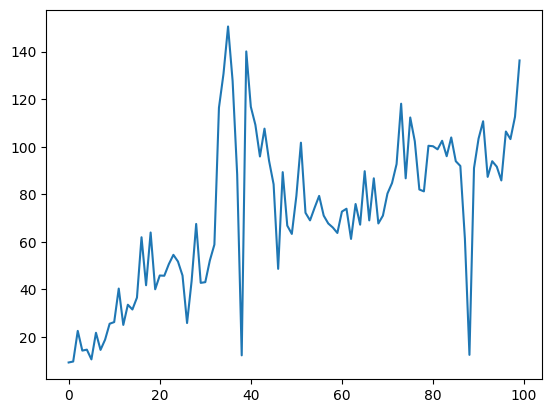

In [14]:
model = NN()
agent = DQNAgent(state_size, action_size, model)
done = False
evaluations = []
for e in range(n_episodes):
    state = env.reset()[0]
    for time in range(5000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon}")
            break
    if e % 100 == 0:
        val = eval(env, agent)
        evaluations.append(val)
        if val > 200:
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

plt.plot(evaluations)
plt.show()

All episode lengths: [209, 155, 125, 151, 116]
Average episode length: 151.2


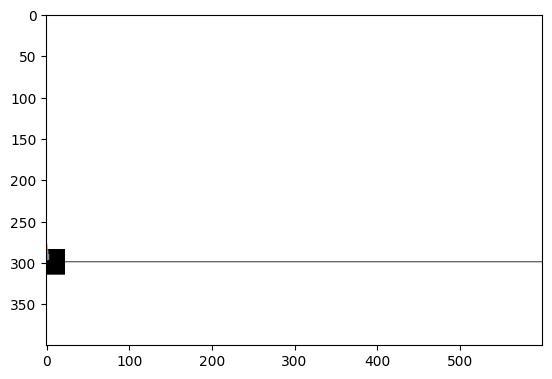

In [15]:
env.reset()
img = plt.imshow(env.render())
episode_lengths = []
for e in range(5):
    state = env.reset()[0]
    done = False
    counter = 0
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        counter += 1
    episode_lengths.append(counter)
print(f"All episode lengths: {episode_lengths}")
print(f"Average episode length: {np.mean(episode_lengths)}")
env.close()